In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import shap

In [2]:
# train_data
df_train, cols, X_train, X_valid, y_train, y_valid = preprocessing(test_size=0.3, file_path='/Users/woojinheo/Desktop/github/SHAP/data/train.csv')

# test_data
df_test, _, X_test, _, y_test, _ = preprocessing(test_size=0, file_path='/Users/woojinheo/Desktop/github/SHAP/data/test.csv')

# GridSearchCV

In [59]:
# model
rf = RandomForestClassifier(random_state=42)

# hyperparameter grid
param_grid = {
    'criterion':['gini','entropy','log_loss'], # loss function
    'n_estimators': [10, 50, 100],          # number of tree
    'max_depth': [None, 10, 20, 30],         # max tree depth
    'min_samples_split': [2, 5, 10],         # min # of sample for node split
    'min_samples_leaf': [1, 2, 4],           # min # of sample for leaf node
    'max_features': ['sqrt', 'log2', None]   # feature selection criterion
}


In [ ]:
# GridSearchCV 
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',         # scoring metric
    cv=5,                 # 5-fold cross validation
    n_jobs=-1,            
    verbose=2             
)

# train
grid_search.fit(X_train, y_train)

# best parmeters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 score:", grid_search.best_score_)

# predict with best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

In [ ]:
# Grid Search result to dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')

# print(results_df)

results_df['criterion'] = results_df['params'].apply(lambda x: x['criterion'])
results_df['max_depth'] = results_df['params'].apply(lambda x: x['max_depth'])
results_df['max_features'] = results_df['params'].apply(lambda x: x['max_features'])
results_df['min_samples_leaf'] = results_df['params'].apply(lambda x: x['min_samples_leaf'])
results_df['min_samples_split'] = results_df['params'].apply(lambda x: x['min_samples_split'])
results_df['n_estimators'] = results_df['params'].apply(lambda x: x['n_estimators'])

results_df.to_excel('./random_forest_gridsearch_result.xlsx')

In [63]:
best_model

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=10, random_state=42)

In [ ]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Neutral or Dissatisfied', 'Satisfied'])
print('random forest','-'*60)
print(report)

random forest ------------------------------------------------------------
                         precision    recall  f1-score   support

Neutral or Dissatisfied       0.96      0.98      0.97     14573
              Satisfied       0.97      0.94      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976



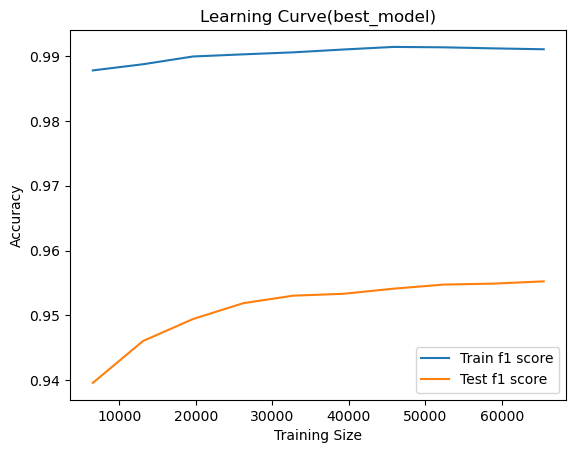

In [101]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=10, scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train f1 score")
plt.plot(train_sizes, test_scores_mean, label="Test f1 score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve(best_model)")
plt.show()

In [ ]:
# new parameter
rf = RandomForestClassifier(n_estimators=10,
                            criterion='entropy', # can be 'entropy or log_loss'
                            max_depth=20,
                            min_samples_split=10,
                            min_samples_leaf=2,
                            # min_weight_fraction_leaf=0.0,
                            max_features=None, # Use the square root of the number of features. Smaller values make trees less complex but faster to train.
                            # min_impurity_decrease=0.0,
                            # bootstrap=True, # If True, each tree is trained on a random sample with replacement.
                            # oob_score=False, # Can provide a quick validation accuracy estimate without needing a separate validation set. but since we already have validation set, no need.
                            # max_samples=None, # The number (or fraction) of samples to draw from X to train each tree if bootstrap=True. None menams all samples are used.
                            # class_weight='balanced', # can have a dictionary mapping class labels to weights. balanced : Adjust weights inversely proportional to class frequencies.
                            # ccp_alpha=0.0, # Higher values result in simpler trees, which can help prevent overfitting
                            random_state=42)

In [89]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=10, random_state=42)

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Performance comparison
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

#  n_estimators=100, min_samples_split=5, min_samples_leaf=5,
print('train_accuracy:',train_accuracy)
print('test_accuracy:',test_accuracy)

train_accuracy: 0.9841197822141561
test_accuracy: 0.9593470896211888


In [100]:
report = classification_report(y_test, y_test_pred, target_names=['Neutral or Dissatisfied', 'Satisfied'])
print('random forest','-'*60)
print(report)

random forest ------------------------------------------------------------
                         precision    recall  f1-score   support

Neutral or Dissatisfied       0.95      0.97      0.96     14573
              Satisfied       0.97      0.94      0.95     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976



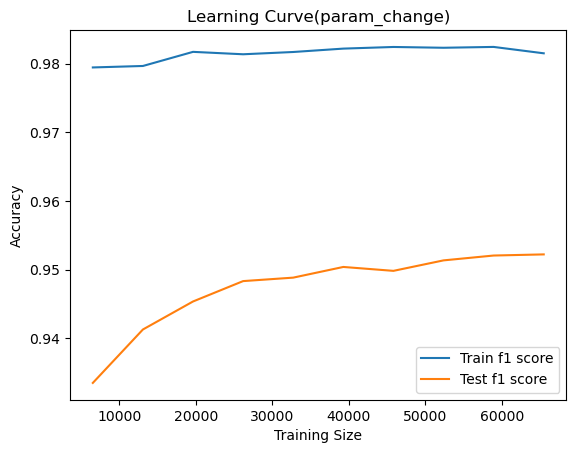

In [102]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=10, scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train f1 score")
plt.plot(train_sizes, test_scores_mean, label="Test f1 score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve(param_change)")
plt.show()

# shap

### global

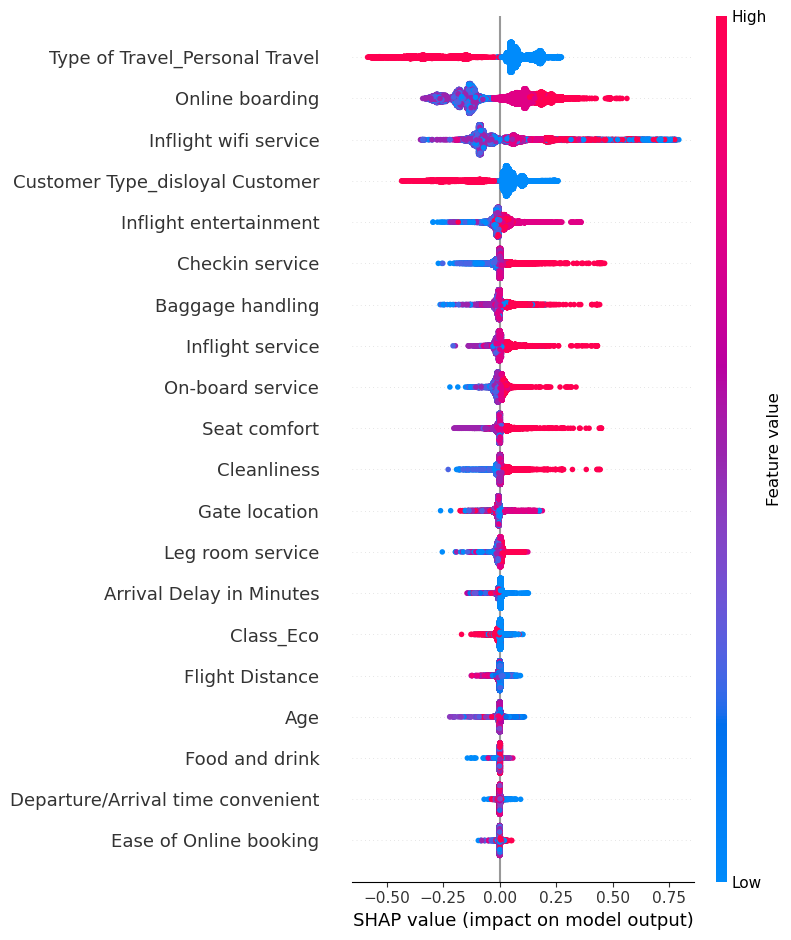

In [ ]:
explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test[:10,:]) # parse partial data
shap_values = explainer.shap_values(X_test)

# Global SHAP Summary Plot
'''
# how to interpret?
color
- red : value of that feature is high
- blue : vlaue of that feature is low

x axis
- 0 : no impact on prediction
- positive(>0) : that feature attribute to label=1(satisfied)
- negative(<0) : that feature attribute to label=0(dissatisfied)

ex) interpretation
# feature importance 
- type of travle (personal travel) is the most important factor to the satisfaction

# each feature
- personal travel have postive affect on increasing satisfaction
- higher satisfaction on online boarding have positive affect on overall satisfaction
'''
shap.summary_plot(shap_values[:, :, 1], pd.DataFrame(X_test, columns=cols), feature_names=np.array(cols))

In [ ]:
# disloyal people's gloabal feature importance

X_test_ = pd.DataFrame(X_test, columns=cols)
X_test_['label'] = y_test

X_disloyal = X_test_[X_test_['Customer Type_disloyal Customer']==0].drop(columns=['label'])
y_disloyal = X_test_[X_test_['Customer Type_disloyal Customer']==0]['label']

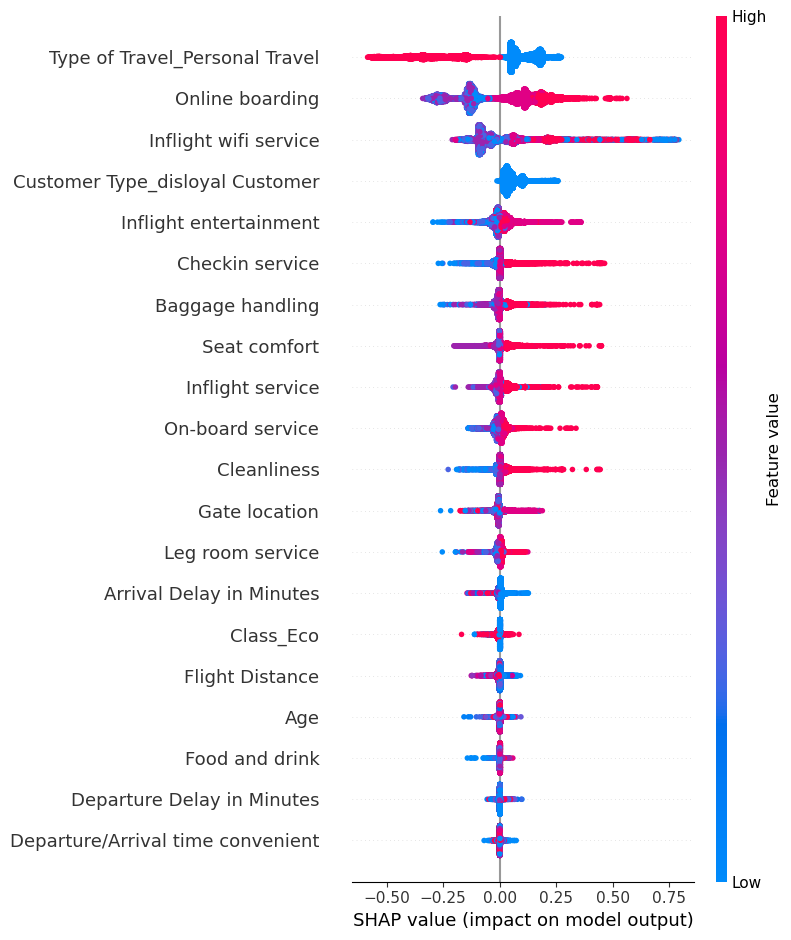

In [113]:
explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test[:10,:]) # parse partial data
shap_values = explainer.shap_values(X_disloyal)

# Global SHAP Summary Plot
shap.summary_plot(shap_values[:, :, 1], pd.DataFrame(X_disloyal, columns=cols), feature_names=np.array(cols))

### local

satisfied:  1
predicted:  1


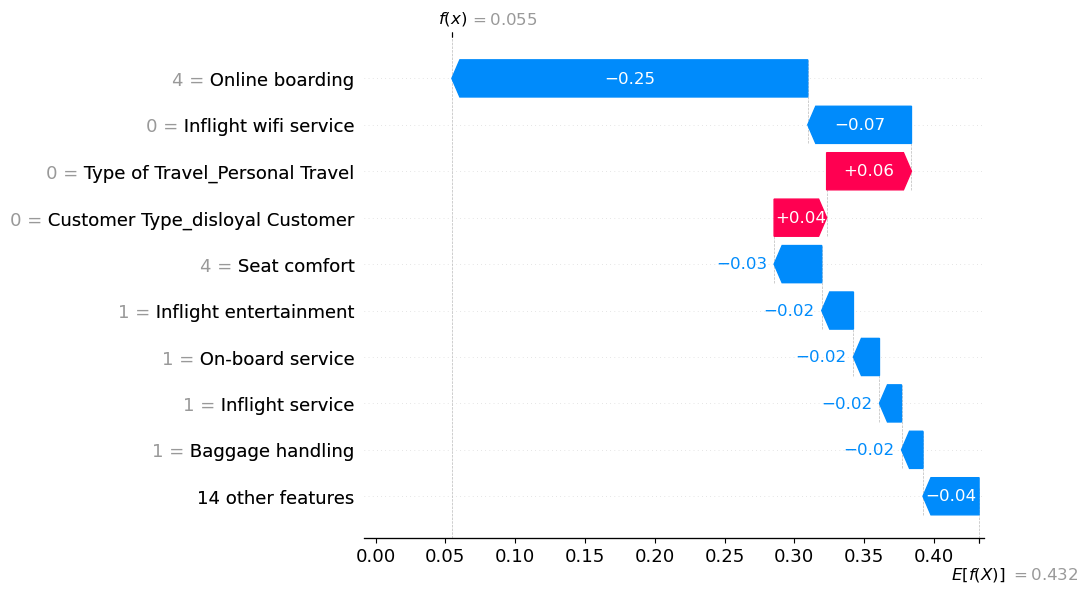

In [ ]:
# individual data point SHAP value Waterfall Plot
''''
structure of the waterfall plot

1.1 Baseline (Expected Value,  E[f(x)] ):

	•	E[f(x)] = 0.432 : This is the average probability of predicting label=1 (satisfied) across the entire dataset.
	•	In other words, this represents the baseline probability of predicting “satisfied” when the model has not observed this specific data point.

1.2 SHAP Values:
	•	Each feature contributes to moving the baseline prediction  E[f(x)] to the final prediction  f(x), indicating the magnitude and direction of its impact.
	•	Red: Increases the prediction value (towards label=1, higher likelihood of satisfaction).
	•	Blue: Decreases the prediction value (towards label=0, higher likelihood of dissatisfaction).

1.3 Final Prediction ( f(x) ):
	•	The final model output is  f(x) = 0.055 .
	•	This means that the probability of this data point being predicted as label=1 (satisfied) is approximately 5.5%.
	•	The model has predicted this data point as dissatisfied (label=0)

'''
i=3
print('satisfied: ',X_test_['label'].loc[i])
print('predicted: ',y_test_pred[i])
shap.plots.waterfall(shap.Explanation(values=shap_values[:, :, 1][i], base_values=explainer.expected_value[1], data=X_test_.iloc[i,:-1]))

In [171]:
X_test_

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,label
0,52.0,160.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,...,5.0,5.0,50.0,44.0,0.0,0.0,0.0,1.0,0.0,1
1,36.0,2863.0,1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20.0,192.0,2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,...,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0
3,44.0,3377.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,...,1.0,4.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,1
4,49.0,1182.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,2.0,...,2.0,4.0,0.0,20.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,34.0,526.0,3.0,3.0,3.0,1.0,4.0,3.0,4.0,4.0,...,5.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
25972,23.0,646.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
25973,17.0,828.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,...,4.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
25974,14.0,1127.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,...,5.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [168]:
shap_values.shape

(21177, 23, 2)